<div width=50% style="display: block; margin: auto">
    <img src="figures/ucl-logo.svg" width=100%>
</div>


### [UCL-ELEC0136 Data Acquisition and Processing Systems 2024]()
University College London

# **Lab Session 6: Data Representation, Modelling & Analysis**

In the first part of this lab, we will use weather data extracted from Meteonorm for five different cities in the world. In the second part of the lab, we will use the London Santander Cycle data as time series data.

### Objectives
* Learn how to understand and cluster linear data with **linear dimensionality reduction** techniques, such as PCA.
* Learn how to analyse non-linear data through **non-linear dimensionality reduction** methods, such as Kernel-PCA.
* Learn to **plot** and represent data and results.
* Learn how to analyse data using different types of plots.
* Learn forecasting data using **Facebook Prophet**.
* Learn time-series **prediction** and **forecasting**.

### Outline
This notebook has 3 main parts:

0. [Setup](#0---setup)
1. [Linear Dimensionality Reduction](#1---linear-dimensionality-reduction-----principal-component-analysis-pca).
2. [Non-Linear Dimensionality Reduction](#2---non-linear-dimensionality-reduction).
3. [Time Series Forecasting](#3---time-series-forecasting).


<hr width=70% style="float: left">

# 0 - Setup
The first thing we need to do is to install the required packages for this lab. The packages we are using are:
- `numpy`: numerical computing library
- `pandas`: data manipulation and analysis library with data structures for efficient data handling and manipulation
- `matplotlib`: plotting library that is suitable for various types of visualizations
- `scikit-learn`: simple and efficient library of tools for data mining and data analysis
- `seaborn`: data visualization library that provides a high-level interface for creating statistical graphics
- `openpyxl`: library for reading and writing Excel files
- `fbprophet`: forecasting library that offers a tool for time series data, and utilizes an additive model to predict trends and seasonality in data with daily observations

<div class="alert alert-block alert-danger" style="border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 0.1: Install the required packages </b>

Add the packages to your requirements file and install all of them.

<summary>🔎 Hint</summary>

Note that:
- you can add fbprophet to your `requirements.txt` file as `prophet` or `fbprophet`.
- if the pip command does not work, try to install it using the conda command: `conda install -c conda-forge fbprophet`.

</div>

# 1 - Linear Dimensionality Reduction ---  Principal Component Analysis (PCA)

Data is one of the main drivers behind most of Machine Learning applications. Analysing the data prior to any usage is of crucial importance since data can be complicated and sometimes may be challenging to understand the meaning of all its components such as data points, attributes, characteristics, variables, and values. These data components collectively represent information within the set of data and it is often complicated to grasp which parts carry information.

Dimensionality reduction is a technique that helps us gain a better macro-level understanding of the data by reducing the number of features that describe a dataset such that only the most information-rich parts remain.

Principal Component Analysis (PCA) is a simple yet powerful technique used for dimensionality reduction. Through it, we can directly decrease the number of feature variables, thereby narrowing down the important features and saving on computations. From a high-level view, PCA has three main steps:

1. Compute the **covariance matrix** of the data.
2. Compute the **eigen values** and **vectors** of this covariance matrix.
3. Use the eigenvalues and vectors to select only the most important feature dimensions that carry enough information to approximate the original data.


**PCA effectively involves computing the eigenvalues and eigenvectors of the input data, and then using these as a new co-ordinate basis.** 


<div width=50% style="display: block; margin: auto">
    <img src="figures/pca.png" width=50%>
</div>

By only keeping the eigenvectors corresponding to the largest eigenvalues, we end up with a reduced set of input coordinates that represent better data features.

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional]</h4>

- Short read: [PCA Explianed Visually](https://setosa.io/ev/principal-component-analysis/), which is the source of the above figure.
- Longer read: [PCA with numpy tutorial](https://plot.ly/python/v3/ipython-notebooks/principal-component-analysis/).

</div>

We will use weather data downloaded using [Meteonorm](https://meteonorm.com/en/download) to illustrate the entire process in the script below.
Meteonorm is a software that collects accurate weather data for representative years and historical time series for any place on Earth. You also have the flexibility to choose from more than 30 different weather parameters to include in your dataset. For this session, we will be using the DEMO version which allows us to download data for only 5 cities in 2005: Bern, Johannesburg, San Francisco, Perth, and Brasilia.



The data is stored in comma-separated (.csv) files called *city_name*-hour.dat.
In this analysis, we have selected the following 7 main weather parameters:
- Global radiation ($W/m^2$)
- Diffuse radiation ($W/m^2$)
- Temperature ($°C$)
- Wind speed ($m/s$)
- Relative humidity ($\%$)
- Cloud cover ($oktas$)
- Precipitation ($mm$)

**NOTE:** In meteorology, an okta is a unit of measurement used to describe the amount of cloud cover.
SKC = Sky clear (0 oktas); FEW = Few (1 to 2 oktas); SCT = Scattered (3 to 4 oktas); BKN = Broken (5 to 7 oktas); OVC = Overcast (8 oktas)

In [1]:
#@title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import the helper functions
from helper_functions import *

%matplotlib inline

In [2]:
#@title Load data
df1 = pd.read_table('./lab6-data/weather-data/Bern-hour.dat', sep=',', header=None)
df2 = pd.read_table('./lab6-data/weather-data/Johannesburg-hour.dat', sep=',', header=None)
df3 = pd.read_table('./lab6-data/weather-data/SanFrancisco-hour.dat', sep=',', header=None)
df4 = pd.read_table('./lab6-data/weather-data/Perth-hour.dat', sep=',', header=None)
df5 = pd.read_table('./lab6-data/weather-data/Brasilia-hour.dat', sep=',', header=None)

`create_dataframe()` is a function that assigns names to the imported dataset's columns and creates a DateTimeIndex for better manipulation of the time-series data. The function also creates an additional **class** column to distinguish each city for the PCA analysis.

In [3]:
#@title Preprocess data frames
df_bern = create_dataframe(df1, cls=0)
df_perth = create_dataframe(df4, cls=1)
df_johannesburg = create_dataframe(df2, cls=2)
df_sanfrancisco = create_dataframe(df3, cls=3)
df_brasilia = create_dataframe(df5, cls=4)

## Applying PCA to two cities

As an example, we have decided to apply the PCA to the cities of Perth and Bern, since they belong to the Southern and Northern hemispheres, respectively. Due to the axial tilt of Earth relative to the Sun and the ecliptic plane, the seasons are inverted between the two hemispheres.

Therefore, we expect to find clear differences in weather data by extracting only the four months in which it is winter in Bern and summer in Perth, i.e. January, February, November, and December. Via PCA, we can reduce the dimensionality of the dataset by projecting the whole data **into the few necessary dimensions to discriminate between the two hemispheres**.

In [4]:
# we can save the desired period by dropping the months in the middle (i.e. March to October)
df_perth_summer = df_perth.drop(df_perth.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)

# print the dataframe to see the table
df_perth_summer

,global radiation,diffuse radiation,temp,wind speed,relative humidity,cloud cover,precipitation,class
DateTime,,,,,,,,
2005-01-01 00:00:00,0,0,24.7,3.3,68,0,0.0,1
2005-01-01 01:00:00,0,0,23.7,2.8,73,0,0.0,1
2005-01-01 02:00:00,0,0,23.1,3.3,70,0,0.0,1
2005-01-01 03:00:00,0,0,22.5,3.6,76,0,0.0,1
2005-01-01 04:00:00,0,0,22.0,2.6,75,0,0.0,1
...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,1,1,23.7,6.9,47,1,0.0,1
2005-12-31 20:00:00,0,0,21.1,6.0,61,1,0.0,1
2005-12-31 21:00:00,0,0,18.5,4.2,75,1,0.0,1


In [5]:
# we can save the desired period, by dropping the months in the middle (i.e. March to October)
df_bern_winter = df_bern.drop(df_bern.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)

# print the dataframe to see the table
df_bern_winter

,global radiation,diffuse radiation,temp,wind speed,relative humidity,cloud cover,precipitation,class
DateTime,,,,,,,,
2005-01-01 00:00:00,0,0,3.1,0.5,82,8,2.9,0
2005-01-01 01:00:00,0,0,3.4,0.2,77,8,0.3,0
2005-01-01 02:00:00,0,0,3.1,0.1,77,8,0.4,0
2005-01-01 03:00:00,0,0,3.1,0.4,77,8,0.1,0
2005-01-01 04:00:00,0,0,3.0,0.4,63,8,0.0,0
...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,0,0,1.9,0.5,63,8,0.0,0
2005-12-31 20:00:00,0,0,1.7,0.2,60,8,0.0,0
2005-12-31 21:00:00,0,0,1.5,0.0,76,8,0.2,0


We create a dataframe called df_pca on which we will performed the PCA algorithm. **At this point, df_pca still contains normal data as PCA has not been performed yet.**

In [14]:
# we now combine (concatenate) the data of both cities to use for our PCA analysis
df_pca = pd.concat([df_bern_winter, df_perth_summer], keys=['Bern','Perth'], axis=0, join='inner')

# print the dataframe to see the table
df_pca

global radiation  diffuse radiation  temp  \
      DateTime                                                         
Bern  2005-01-01 00:00:00                 0                  0   3.1   
      2005-01-01 01:00:00                 0                  0   3.4   
      2005-01-01 02:00:00                 0                  0   3.1   
      2005-01-01 03:00:00                 0                  0   3.1   
      2005-01-01 04:00:00                 0                  0   3.0   
...                                     ...                ...   ...   
Perth 2005-12-31 19:00:00                 1                  1  23.7   
      2005-12-31 20:00:00                 0                  0  21.1   
      2005-12-31 21:00:00                 0                  0  18.5   
      2005-12-31 22:00:00                 0                  0  16.0   
      2005-12-31 23:00:00                 0                  0  13.4   

                           wind speed  relative humidity  cloud cover  \
      DateTime                                                          
Bern  2005-01-01 00:00:00         0.5                 82            8   
      2005-01-01 01:00:00         0.2                 77            8   
      2005-01-01 02:00:00         0.1                 77            8   
      2005-01-01 03:00:00         0.4                 77            8   
      2005-01-01 04:00:00         0.4                 63            8   
...                               ...                ...          ...   
Perth 2005-12-31 19:00:00         6.9                 47            1   
      2005-12-31 20:00:00         6.0                 61            1   
      2005-12-31 21:00:00         4.2                 75            1   
      2005-12-31 22:00:00         3.5                 83            1   
      2005-12-31 23:00:00         3.5                100            1   

                           precipitation  class  
      DateTime                                   
Bern  2005-01-01 00:00:00            2.9      0  
      2005-01-01 01:00:00            0.3      0  
      2005-01-01 02:00:00            0.4      0  
      2005-01-01 03:00:00            0.1      0  
      2005-01-01 04:00:00            0.0      0  
...                                  ...    ...  
Perth 2005-12-31 19:00:00            0.0      1  
      2005-12-31 20:00:00            0.0      1  
      2005-12-31 21:00:00            0.0      1  
      2005-12-31 22:00:00            0.0      1  
      2005-12-31 23:00:00            0.0      1  

[5760 rows x 8 columns]

Here, we define the inputs (X) to the PCA algorithm to be all the weather parameters, and the target (y) is the city identifier, *class*.

In [7]:
# extract the values of the features / attributes of the data from the DataFrame 'df_pca'
X = df_pca.loc[:, 'global radiation':'precipitation'].values

# extract the values of the target variable ('class') from the DataFrame 'df_pca'
y = df_pca.loc[:, 'class'].values

PCA returns a sub-space that maximizes the variance along the feature vectors. Therefore, to properly measure the variance of those feature vectors, the distribution of values on each feature must be of equal variance (otherwise the PCA algorithm would be biased towards features with large variance and range). 

To do this, we first normalise our data to have zero mean and unit-variance such that each feature will be weighted equally in our calculations.

This is done by using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) module in **scikit-learn**.

In [8]:
# import StandardScaler from the scikit-learn package
from sklearn.preprocessing import StandardScaler

# scale the input features of the data
X_std = StandardScaler().fit_transform(X)

scikit-learn implements a module for computing the PCA: `fit_transform()`. You can specify the desired number of principal components or you can take the ones that hold most of the variance (or information) about the dataset. Depending on the problem and the data, the first 2 or 3 principal components can be sufficient.

In [24]:
from sklearn.decomposition import PCA

# creating the PCA model
pca = PCA()

# using the PCA model on our standardized data
Y = pca.fit_transform(X_std)

# contains the proportion of the total variance in the data explained by each principal component
print(pca.explained_variance_ratio_)
print(Y.shape)

[0.50115394 0.17166543 0.13596841 0.08312551 0.05264011 0.03358018
 0.02186641]
(5760, 7)


How much of the variance is explained by the first two principal components?

Let's see whether or not it is enough to clearly distinguish between Bern and Perth.

Here is an example of how the data looks like for the first principal component.

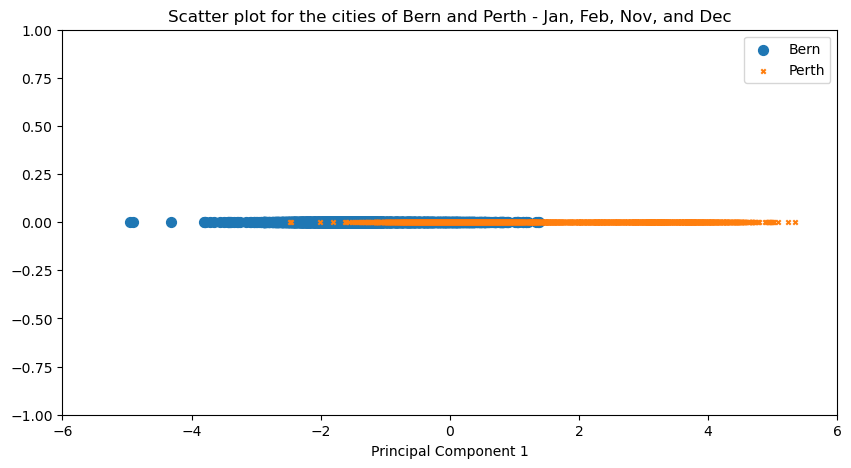

In [10]:
# create a new figure and axis for plotting with a specified size
fig, ax = plt.subplots(figsize=(10, 5))

# create a scatter plot for data points corresponding to 'Bern' (class 0), using 'o' markers and labeling as 'Bern'
ax.scatter(Y[:, 0][y == 0], np.zeros((Y[y == 0].shape[0], 1)), marker='o', s=50, label='Bern')

# create a scatter plot for data points corresponding to 'Perth' (class 1), using 'x' markers and labeling as 'Perth'
ax.scatter(Y[:, 0][y == 1], np.zeros((Y[y == 1].shape[0], 1)), marker='x', s=10, label='Perth')

# set the x-axis limits to [-6, 6]
ax.set_xlim([-6, 6])

# set the y-axis limits to [-1, 1]
ax.set_ylim([-1, 1])

# set the x-axis label
ax.set_xlabel('Principal Component 1')

# set the title for the plot
ax.set_title('Scatter plot for the cities of Bern and Perth - Jan, Feb, Nov, and Dec')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

You can see that there is a big overlap between the two classes (cities).


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 1.1: Plot the principal components </b>

Plot the 2D scatterplot with the first two principal components.

</div>

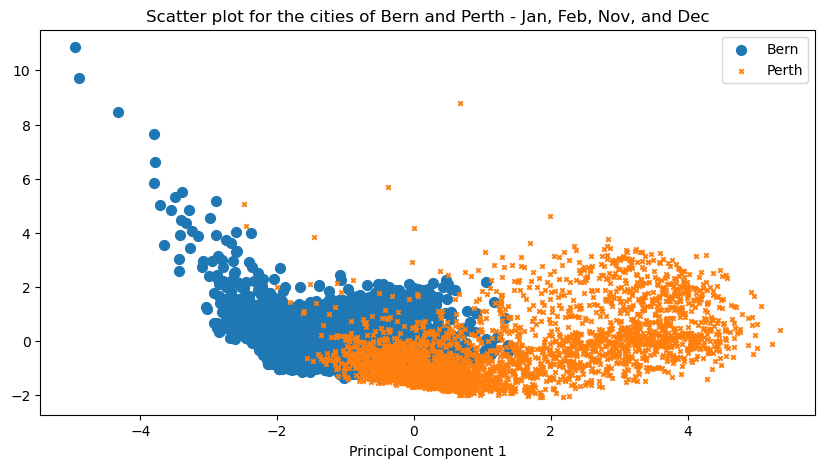

In [27]:
###########################
# Task:
#   Scatterplot with the first two principal components
###########################
# create a new figure and axis for plotting with a specified size

fig, ax = plt.subplots(figsize=(10, 5))

# create a scatter plot for data points corresponding to 'Bern' (class 0), using 'o' markers and labeling as 'Bern'
ax.scatter(Y[:,0][y == 0],Y[:,1][y == 0], marker='o', s=50, label='Bern')

# create a scatter plot for data points corresponding to 'Perth' (class 1), using 'x' markers and labeling as 'Perth'
ax.scatter(Y[:,0][y == 1],Y[:,1][y == 1], marker='x', s=10, label='Perth')
'''
# set the x-axis limits to [-6, 6]
ax.set_xlim([-12, 12])

# set the y-axis limits to [-1, 1]
ax.set_ylim([-6, 6])
'''
# set the x-axis label
ax.set_xlabel('Principal Component 1')

# set the title for the plot
ax.set_title('Scatter plot for the cities of Bern and Perth - Jan, Feb, Nov, and Dec')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 1.2: Plot the principal components </b>

Plot the 3D scatterplot using the first three principal components.

</div>

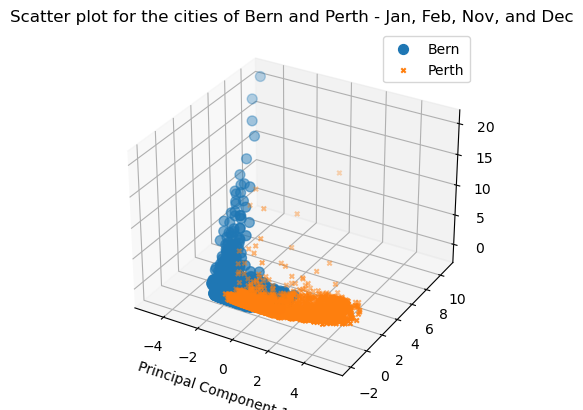

In [30]:
# how to generate 3d figures using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# create a scatter plot for data points corresponding to 'Bern' (class 0), using 'o' markers and labeling as 'Bern'
ax.scatter(Y[:,0][y == 0],Y[:,1][y == 0],Y[:,2][y == 0], marker='o', s=50, label='Bern')

# create a scatter plot for data points corresponding to 'Perth' (class 1), using 'x' markers and labeling as 'Perth'
ax.scatter(Y[:,0][y == 1],Y[:,1][y == 1],Y[:,2][y == 1], marker='x', s=10, label='Perth')
'''
# set the x-axis limits to [-6, 6]
ax.set_xlim([-12, 12])

# set the y-axis limits to [-1, 1]
ax.set_ylim([-6, 6])
'''
# set the x-axis label
ax.set_xlabel('Principal Component 1')

# set the title for the plot
ax.set_title('Scatter plot for the cities of Bern and Perth - Jan, Feb, Nov, and Dec')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

### TO DO

<div class="alert alert-block alert-danger">
<b>Q: What happens when your data is linearly inseparable / dependent?</b>
</div>

<div class="alert alert-block alert-danger">
<b>Q: Was the data used in the  first part of this session linearly separable?</b>
</div>

Note that that PCA is a linear projection technique.

## 2 - Non Linear Dimensionality Reduction


### 2.1 Kernel Principal Component Analysis (K-PCA)

The first non-linear approach we will look at is Kernel PCA which uses a non-linear kernel function with standard PCA to achieve non-linear dimensionality reduction. In practice, it projects the linearly inseparable data into a higher dimensional space that can be linearly separated using PCA. The main steps of KPCA are:
1. Select a non-linear kernel mapping
2. Construct the normalized kernel matrix
3. Find the eigenvalues and vectors of this matrix
4. For each data point, use the eigenvalues and vectors to obtain its principal components.

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional]</h4>

- Most common kernel functions are Gaussian, Sigmoid and Polynomial. You can learn more details about Kernel PCA [here](http://axon.cs.byu.edu/~martinez/classes/778/Papers/KernelPCA.pdf).
- You might also find it useful to read about [Kernel SVM](https://scikit-learn.org/stable/modules/svm.html) since it has many conceptual similarities to  Kernel PCA.

</div>

For this part, we will use the same dataset as in the first part but the analysis will be done for different cities. We will apply the Kernel PCA to the cities of Perth and Johannesburg and we are going to use only January, February, November, and December when it is summer in both of these cities.

In [31]:
#@title Load and preprocess data as in PCA but just for 'Perth' and 'Johannesburg'
df2 = pd.read_table('./lab6-data/weather-data/Johannesburg-hour.dat', sep=',', header=None)
df4 = pd.read_table('./lab6-data/weather-data/Perth-hour.dat', sep=',', header=None)

# use the same create_dataframe() function used in task 6.1 to create the dataframes
df_perth = create_dataframe(df4, cls=1)
df_johannesburg = create_dataframe(df2, cls=2)

# identify the desired period by dropping the months in the middle (i.e. March to October)
df_perth_summer = df_perth.drop(df_perth.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)
df_johannesburg_summer = df_johannesburg.drop(df_johannesburg.loc['2005-03-01 00:00:00':'2005-10-31 23:00:00', :].index, axis=0)

# combine (concatente) the data of both cities for our PCA analysis
df_pca = pd.concat([df_perth_summer,df_johannesburg_summer], keys=['Perth','Johannesburg'], axis=0, join='inner')

# print the resulting dataframe
df_pca

# define the input parameters (X) and the target vairbale (y)
# extract the values of the features ('global radiation' to 'precipitation') from the DataFrame 'df_pca'
X = df_pca.loc[:, 'global radiation':'precipitation'].values

# extract the values of the target variable ('class') from the DataFrame 'df_pca'
y = df_pca.loc[:, 'class'].values

# scale the data using StandardScaler already imported in task 6.1
# StandardScaler scales the data by ensuring that the transformed data has a mean of 0 and a standard deviation of 1 for each feature
X_std = StandardScaler().fit_transform(X)

Similar to PCA, scikit-learn provides `fit_transform()` for calculating Kernel PCA. You can specify different arguments such as the number of principal components, the kernel function, and parameters related to them.

In [32]:
from sklearn.decomposition import KernelPCA

# create a KernelPCA (Kernel Principal Component Analysis) model using the Radial Basis Function (RBF) kernel
kpca = KernelPCA(kernel='rbf')
# fit the model to the standardized data 'X_std' and transform it to 'Y_k' using kernel-based dimensionality reduction
Y_k = kpca.fit_transform(X_std)


Compute the explained variance and ratio since kernel PCA does not have a built-in function.

In [34]:
# calculate the explained variance for each principal component in 'Y_k' by computing the variance along each axis
explained_variance = np.var(Y_k, axis=0)

# compute the explained variance ratio for each principal component by dividing the explained variance by the total variance
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# the 'explained_variance_ratio' now contains the proportion of total variance explained by each principal component
print(explained_variance_ratio)

[2.16785167e-01 1.17533600e-01 8.86260687e-02 ... 2.19434199e-13
 2.17844629e-13 2.17285879e-13]


<div class="alert alert-block alert-danger" style="border: 1px solid blue; padding: 10px;">
<b>👩‍💻👨‍💻 Task 2.1: Separate the data and plot the principal components </b>

- Use PCA to separate the data.
- Plot the 3D scatterplot with the first three principal components.

<summary>🔎 Hint</summary>

You can use the function `plot_3d_vis()` that we wrote for you to make the plotting of the 3D principal components easier and faster. This function takes as input: 
- `Y`: the transformed data.
- `y`: the target variable.
- `label_1`: the label for the first set of data.
- `label_2`: the label for the second set of data.
- `title`: the title of the 3D scatterplot.

</div>

In [ ]:
###########################
# Task:
#   Use PCA for dimensionality reduction
###########################

plot_3d_vis()

### TO DO


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 2.2: Different kernel functions </b>

Try different kernel functions and **compare** the results by visualizing. Try these functions:
- poly.
- sigmoid.
- cosine.
- linear.

<summary>🔎 Hint</summary>

You can also use the function `plot_3d_vis()` for plotting the 3D principal components.
</div>

In [ ]:
###########################
# Task:
#   Use kernel=poly, cosine, precomputed in KernelPCA
###########################

### TO DO
# using the poly kernel


In [ ]:
### TO DO
# using the cosine kernel


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 2.3: Try a linear kernel function </b>

- What happens when you select a linear kernel? 
- Can you compare the results to standard PCA?

</div>

In [ ]:
###########################
# Task:
#   Use kernel=linear in KernelPCA
###########################

# using a linear kernel


Comparing the results above for the three different kernel functions (poly, cosine, and linear), we notice that:


1.   when plotting the principal components of the 'poly' function, the points are compacted in a small portion of the space.
2.   whereas, when plotting the principal components of the 'cosine' function, the points are widely distributed in the space, creating a spherical form with the points of both cities strongly overlapping.
3. lastly, when plotting the principal components of the 'linear' function, the points are scattered in the space showing the difference between the two distinct cities.



### **[OPTIONAL]** 2.2 t-Distributed Stochastic Neighbor Embedding (t-SNE) (up to the student)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear approach for dimensionality reduction used for exploring and visualizing high-dimensional data. It uses gradient descent to minimize the Kullback-Leibler divergence between the distribution that measures pairwise similarities of the original high-dimensional inputs and the distribution that measures pairwise similarities of the corresponding embedded in lower-dimension points.

You can find a summary of the algorithmic steps [here](https://uk.mathworks.com/help/stats/t-sne.html) or more details in the [original paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

There are quite a few hyperparameters to control during the optimization process (e.g. perplexity, learning rate, number of iterations, etc.).

You can find a very informative guide on how to deal with different situations on [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/ ).

The `sklearn.manifold` module implements the t-distributed Stochastic Neighbor Embedding. We apply the t-SNE on the same data we defined in task 2.1.

In [ ]:
from sklearn import manifold

# create a t-SNE object with specified parameters
tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=5)

# transform the input data 'X' into a 2D space using t-SNE
Y = tsne.fit_transform(X)

# print the shape of the transformed data (number of data points, 2 dimensions)
Y.shape

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 2.4: Visualize </b>

Visualize the results of t-SNE.

</div>

In [ ]:
###########################
# Task:
#   3D Scatterplot with the transformed output of t-SNE
###########################

### TO DO


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 2.5: Experiment with perplexity </b>

Increase the perplexity a lot. What do you notice? What happens when it is higher that the data points? You can also try to change other parameters and compare to see their effect on the outcome.

Plot and visualize.

</div>

In [ ]:
###########################
# Task:
#   Change perplexity parameter
###########################

### TO DO

In [ ]:
# visualization

### TO DO


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 [OPTIONAL]: Task 2.6: Compare t-SNE to PCA </b>

- Compare t-SNE results to PCA. What are the advantages and disadvantages of each approach? What happens if you use PCA before t-SNE?

- Plot and visualize the 3D scatterplot.

</div>

In [ ]:
###########################
# Task:
#   Use PCA for dimensionality reduction
###########################


### TO DO

In [ ]:
###########################
# Task:
#   3D Scatterplot of the t-SNE and PCA results
###########################


### TO DO

## 3 - Time Series Forecasting

This lab session addresses the common problems of modeling time series data to make predictions on their future behavior.

We will use the [**London Santander Cycle data**](https://data.london.gov.uk/dataset/number-bicycle-hires) provided by Transport for London (TfL) to experiment with time series data.

As reported on the TfL website, the dataset includes the total number of hires of the Santander Cycle Hire Scheme, by day, month, and year for each day since the launch on 30 July 2010.

For this session, we are interested only in the daily data (i.e. columns A and B).

In [35]:
#@title Imports
import pickle
import seaborn as sns
from calendar import day_abbr, month_abbr, mdays

## Load data and plot

The dataset contains two sheets: `Metadata` and `Data`. Therefore, we need to instruct Pandas on which one we would like to look at, by using the `sheet_name` attribute of the `read_excel` method. Moreover, since there is no need to load data that we are not interested in, it is recommended to specify the columns that we want to use.

**NOTE:** The timestamp (which is `Day` in the Excel file) is renamed `datetime` due to a common practice in Pandas. Also, we are selecting the dates from the 1st of Jan 2011 because the climate data that we will be using later in the session is from this date onwards.

In [36]:
# we used the helper function extract_csv_from_excel() to extract the information that we only need from the excel file and turn it to csv
extract_csv_from_excel()

In [37]:
# we used the load_tfl_cycle_data() function to load the csv file and rename the timestamp
cycle_df = load_tfl_cycle_data()
cycle_df

,Number of Bicycle Hires
datetime,
2011-01-01,4555
2011-01-02,6250
2011-01-03,7262
2011-01-04,13430
2011-01-05,13757
...,...
2020-09-26,34338
2020-09-27,26681
2020-09-28,33130


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.1: Plot time series </b>

Plot the cycle data time series.
</div>

In [ ]:
#### TODO ####
#### Plot the cycle data time series ####


##############

## 3.1. Exploratory data analysis

Let's now explore the properties of the dataset. Time series data normally comprises three main components:
- Trend represents the overall tendency of the data to increase or decrease over time.
- Seasonality is related to the presence of recurrent patterns that appear after regular intervals (like seasons).
- Random noise is often hard to explain and represents all those changes in the data that seem unexpected. Sometimes sudden changes are related to fixed or predictable events (i.e., public holidays).

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

* You can go back to 'Lab 4 - Data Processing 2' for references on EDA.

</div>


### 3.1.1 Explore seasonal cycles using a 30-day rolling average

In [ ]:
# Calculate the seasonal cycle by taking a rolling mean with a window of 30 days
seasonal_cycle = cycle_df.rolling(window=30, center=True).mean().groupby(cycle_df.index.dayofyear).mean()

# Calculate the 25th percentile (q25) of the seasonal cycle
q25 = cycle_df.rolling(window=30, center=True).mean().groupby(cycle_df.index.dayofyear).quantile(0.25)

# Calculate the 75th percentile (q75) of the seasonal cycle
q75 = cycle_df.rolling(window=30, center=True).mean().groupby(cycle_df.index.dayofyear).quantile(0.75)


In [ ]:
# Modify the element at index 2 to 29, which represents February's number of days in a leap year
ndays_m = mdays.copy()
ndays_m[2] = 29

# Compute the cumulative sum, which gives the cumulative day-of-year values for each month
ndays_m = np.cumsum(ndays_m)

# Define month ticks
month_ticks = month_abbr[1:]

# Create a figure and axis for plotting with a specified size
f, ax = plt.subplots(figsize=(10, 7))

# Plot the 'seasonal_cycle'
seasonal_cycle.plot(ax=ax, lw=2, color='b', legend=False)

# Fill the area between the 25th and 75th percentiles with a blue color
ax.fill_between(seasonal_cycle.index, q25.values.ravel(), q75.values.ravel(), color='b', alpha=0.3)

# Set the x-axis tick labels
ax.set_xticklabels(month_ticks)

# Add gridlines
ax.grid(ls=':')

# Set the x-axis and y-axis labels
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Number of Santander cycles hires', fontsize=15)

# Set the x-axis and y-axis limits to focus on specific data ranges
ax.set_xlim(0, 365)
ax.set_ylim(10000, 40000)

# Adjust the font sizes of x-axis and y-axis tick labels
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# Set the title
ax.set_title('30 days running average hourly cycling counts', fontsize=15)

# Display
plt.show()


### 3.1.2 Explore dependency on year and month via carpet plot/heatmap

Heatmaps (also called carpet plots) can give us useful information about the structure of the data. Pandas provides very handy functions to explore relevant dependencies. For example, here we show how the mean Number of Santander Cycles Hires varies as a function of the year and month.

Although the number of hires seems to be increasing over time, this increase is not monotonic and probably depends on other factors as well. On the other hand, the carpet plot confirms the general trend shown before, with higher usage of rented bikes over the warmer months.

In [ ]:
# create a copy of the 'cycle_df' DataFrame to avoid modifying the original data
month_year = cycle_df.copy()

# extract the year and month components from the index and add them as new columns
month_year.loc[:,'year'] = month_year.index.year
month_year.loc[:,'month'] = month_year.index.month

# group the data by year and month, and calculate the mean for each group
# then unstack the grouped data to create a pivot table with years as columns and months as rows
month_year = month_year.groupby(['year','month']).mean().unstack()

# Remove the top-level column index (in this case, the 'year' level)
month_year.columns = month_year.columns.droplevel(0)

# display the DataFrame
month_year


In [ ]:
# create a figure and axis for the heatmap with a specific size
f, ax = plt.subplots(figsize=(12,6))

# create a heatmap plot, specifying the data, axis, colormap, and colorbar settings
sns.heatmap(month_year, ax=ax, cmap=plt.cm.viridis, cbar_kws={'boundaries':np.arange(10000,45000,5000)})

# get the colorbar axis
cbax = f.axes[1]

# set the font size for colorbar tick labels
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]

# set the colorbar label
cbax.set_ylabel('Santander cycles hires', fontsize=13)

# add horizontal gridlines
[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]

# add vertical gridlines
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)]

# set a title
ax.set_title('Santander cycles hires per year and month', fontsize=16)

# set the font size for x-axis tick labels
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]

# set the font size for y-axis tick labels
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# set x-axis label
ax.set_xlabel('Month', fontsize=15)

# set y-axis label
ax.set_ylabel('Year', fontsize=15)

# rotate the ticklabels for the y-axis
ax.set_yticklabels(np.arange(2011, 2021, 1), rotation=0);

### 3.1.3 Explore dependency on day of the week and month via carpet plot/heatmap

<div class="alert alert-block alert-danger" style="border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.2: Heatmap that shows dependencies </b>

- Produce a new heatmap showing the dependency on the day of the week and month.
- Explore dependency on day of the week and month

</div>

In [ ]:
# Explore dependency on day of the week and month




`plot_heatmap()` is a helper function that we wrote for you to make it faster to plot the heatmaps for this particular example.

In [ ]:
plot_heatmap(month_day, 'Santander cycles hires per day of the week and month', 'Month', 'Day of the week')

### 3.1.4 Explore weekdays and weekends trends
<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.3: Differences between weekday and weekend trends </b>

- We can also explore deeper trends by looking at differences between weekdays and weekends.
- Extract weekday and weekend trends.
- Plot weekdays and weekends general trends along with the 25% and 75% IQR to have a sense of the variation over time


<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

* Pandas DateTime indexes have a built-in method that extracts the day of week (`DataFrame.index.dayofweek`), where 0 is Monday and 6 is Sunday.

</div>

In [ ]:
## Extract weekdays and weekends trends ##



In [ ]:
## Plot weekdays and weekends general trends along with the 25% and 75% IQR to have a sense of the variation over time ##


##########################

## 3.2. Forecasting using Facebook Prophet

Nowadays, there are many models for the predictive analysis of time series data such as ARIMA (**A**uto-**R**egressive **I**ntegrated **M**oving **A**verage model), Auto-Regressive models, Exponential Smoothing, LSTM (**L**ong **S**hort **T**erm **M**emory), etc.

Here, we will show how to use a novel approach based on the *Facebook Prophet* library. Fbprophet implements a Generalized Additive Model and models a time series as the sum (or multiplication) of different components (trends, periodic components, holidays, and special events) allowing the incorporation of additional regressors taken from outer sources.
The main reference is [Taylor and Letham, 2017](https://peerj.com/preprints/3190.pdf)

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional] - Readings</h4>

* The main reference for Fbprophet, [Taylor and Letham, 2017](https://peerj.com/preprints/3190.pdf).
* [Official announcement](https://research.fb.com/prophet-forecasting-at-scale/) of Fbprophet.
* [Full documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api) of Fbprophet.

</div>

The easiest way to install Prophet is through conda-forge. Open the Anaconda Prompt and type: `conda install -c conda-forge fbprophet`.

As largely explained in the quick start webpage, Prophet follows the `sklearn` model API. Hence we just need to create an instance of the Prophet class and then call its `fit` and `predict` methods.

The input to Prophet is always a data frame with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric and represents the measurement we wish to forecast.

In [ ]:
from prophet import Prophet

### 3.2.1 Base model

We first prepare the data in order to be ingested by Prophet. Therefore, we must change the name of the datetime column to `ds` and the target feature to `y`.

We will use the helper function `prepare_data()` to do this task. This function takes in the `data` and `target_feature` as inputs.

In [ ]:
# create a new DataFrame 'cycle_df_new' by preparing the 'cycle_df' for Facebook Prophet
cycle_df_new = prepare_data(data=cycle_df, target_feature='Number of Bicycle Hires')

# display the first 5 rows of cycle_df_new
cycle_df_new.head(5)

#### 3.2.1.1 The holidays package

Knowing when holidays and special events take place is often crucial when modelling time-series data. Here we make use of the `holidays` [package](https://github.com/dr-prodigy/python-holidays).

In [ ]:
import holidays

# create an empty DataFrame 'holidays_df' with columns 'ds' and 'holiday'
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

# initialize empty lists to store holiday dates and names
ldates = []
lnames = []

# loop through the holidays in the United Kingdom for the specified years (2011 to 2020)
for date, name in sorted(holidays.UnitedKingdom(years=np.arange(2011, 2020 + 1)).items()):
    # append the holiday date to the 'ldates' list
    ldates.append(date)
    # append the holiday name to the 'lnames' list
    lnames.append(name)

# convert the 'ldates' and 'lnames' lists into NumPy arrays
ldates = np.array(ldates)
lnames = np.array(lnames)

# assign the 'ldates' to the 'ds' column and 'lnames' to the 'holiday' column of 'holidays_df'
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames

# display the unique holiday names in the 'holiday' column
holidays_df.holiday.unique()

In [ ]:
# remove the string ' (Observed)' from each holiday name
# using the apply method with a lambda function to modify the 'holiday' column
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))

# display the first 5 rows of the modified 'holidays_df'
holidays_df.head(5)

#### 3.2.1.2 Train test split and model fit

We have decided to use the data up to the 31st of July to train the model and the rest (last 2 months) as the holdout test set.

You can use the helper function `train_test_split()` to split your data as mentioned above. The function only takes the `data` as input and return both the `train` and `test` sets.

In [ ]:
def train_test_split(data):
    # set the 'ds' column as the index and extract rows up to July 31, 2020 for the training set
    train = data.set_index('ds').loc[:'2020-07-31', :].reset_index()

    # set the 'ds' column as the index and extract rows from August 1, 2020, for the testing set
    test = data.set_index('ds').loc['2020-08-01':, :].reset_index()

    # return the training and testing sets as seperate DataFrames
    return train, test

In [ ]:
# Use the 'train_test_split' function to split the 'cycle_df_new' DataFrame into 'train' and 'test' DataFrames
train, test = train_test_split(data=cycle_df_new)

# Display the first few rows of the 'train' DataFrame
train.head()


We now create a Prophet instance. The model has several parameters, the most important ones being the seasonalities. Here we set all the seasonalities but the daily to True (the data is daily, therefore we can't model in-day cycles).

Here we instantiate the simplest Prophet model, but you can set other parameters such as the prior scales for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.
Normally, larger prior scales and a higher order Fourier series will make the model more flexible, but at the cost of a potential overfit. Setting the hyperparameters is of crucial importance and it is normally done via cross-validation.

In [ ]:
# create a Prophet model (m) with the specified configuration settings:
m = Prophet(
    holidays=holidays_df,  # using the 'holidays_df' DataFrame to specify holidays
    seasonality_mode='multiplicative',  # setting seasonality mode to 'multiplicative'
    yearly_seasonality=True,  # enabling yearly seasonality
    weekly_seasonality=True,  # enabling weekly seasonality
    daily_seasonality=False  # disabling daily seasonality
)


In [ ]:
# fit the Prophet model 'm' to the training data 'train'
m.fit(train)

The method `make_future_dataframe` creates an extension to the training data in the "future". Here our future is obviously the test set.

In [ ]:
# use the Prophet model 'm' to generate a 'future' DataFrame with dates for the forecasting period
future = m.make_future_dataframe(periods=len(test), freq='1D')

# display the last few rows of the 'future' DataFrame
future.tail()

The `predict` method produces a comprehensive DataFrame comprising of all the modelled components of the time-series.

In [ ]:
# use the Prophet model 'm' to make forecasts for the 'future' DataFrame
forecast = m.predict(future)

# display the forecasted results
forecast

In [ ]:
# use the Prophet model 'm' to generate component plots for the 'forecast' data
# and display them in a figure
f = m.plot_components(forecast, figsize=(12, 16))

In the following tasks, we make use of the functions:
- `make_predictions_df`, which is a function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end.
- `plot_predictions`, which is a function that plots the predictions.

Since the target must be strictly positive (but our model doesn't know it), we clip predictions and confidence bands to have a lower value of 0.

In [ ]:
# use the 'make_predictions_df' function to make predictions on our forecasted data
result = make_predictions_df(forecast, train, test)

# update the 'result' DataFrame by clipping 'yhat,' 'yhat_lower,' and 'yhat_upper' values to be no lower than 0
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)

# display the first few rows
result.head()

In [ ]:
# use the 'plot_predictions' function to create a plot of the predictions starting from '2019-01-01'
f, ax = plot_predictions(result, '2019-01-01')

At first glance, we can see that the model is not performing well. That is, it can capture the overall trend of the data in terms of annual and weekly oscillations but is not able to generalise well on unseen data. We can spot the poor performance by employing a joint plot.

We make use of the `create_joint_plot()` helper function to plot this. It takes the `forecast` (forecasted data) as input, as well as labels for the x and y axes, and a title for the plot.

In [ ]:
# create a joint plot for the training set (up to '2020-07-31')
create_joint_plot(result.loc[:'2020-07-31', :], title='Train set')

In [ ]:
# create a joint plot for the testing set (from '2020-08-01' onwards)
create_joint_plot(result.loc['2020-08-01':, :], title='Test set')

## **[OPTIONAL]** 3.2.2 Model with extra-regressors: incorporating the effect of climate conditions (up to the student)

The data is not enough to model the temporal evolution of the number of Santander Cycles Hires. Data scientists should be able to gather external data that they think might be useful for the problem at hand. In this case, is quite clear that weather conditions should strongly influence the amount of Londoners renting bikes.

In [ ]:
# read the DataFrame from a pickled file and assign it to 'df_weather'
df_weather = pd.read_pickle('./lab6-data/tfl-data/LondonWeatherHourly.pkl')

# display the DataFrame
df_weather

The weather data from a station located in NW3 is recorded every hour and reports the average temperature, wind speed, rain, and cloud cover. For our purposes, we have to resample the data daily. Be careful though, bike rentals mostly happen during the daytime, when people commute between home and work or other places. Therefore, we must label the daytime hours before resampling.

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.4: Creating a new column with is_daytime_hour() function </b>

We provide a simple helper function called `is_daytime_hour()` that labels as 1 the hours between 6 am and 8 pm and 0 otherwise. Use the `.apply` method in Pandas to create a new column in the DataFrame called `is_daytime_hour`. Then drop all the rows where the label is 0, because we will not consider those in the resampling process.

<div>

In [ ]:
def is_daytime_hour(datetime):
    # check if the hour component falls between 6 and 20 (inclusive)
    if 6 <= datetime.hour <= 20:
        return 1 # return 1 if it's a daytime hour
    else:
        return 0 # return 0 it it's not a daytime hour

In [ ]:
### TODO ###


##########

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.5: Resampling the data </b>

Now, we can resample the data on a daily basis using the well-known `.resample` method in Pandas.

Resample the data on a daily basis. Check that the length of the resampled DataFrame matches the length of the Cycle DataFrame (3561 rows)

**NOTE** Features like temperature, wind speed and cloud cover can be averaged over the day when resampling. Whereas the precipation is cumulative over the day and taking the average value would not be a reasonable choice.

<div>

In [ ]:
# Resample the data on a daily basis. Check that the length of the resampled DataFrame matches the
# length of the Cycle DataFrame (3561 rows)



<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.6: Concatenate the original data with the weather data </b>

Concatenate the `cycle_df_new` DataFrame obtained earlier with the resampled weather data.

<div>


In [ ]:
# Concatenate the 'cycle_df_new' DataFrame with the selected columns from the 'df_weather_resampled' DataFrame,
# and reset the index to create 'df_with_weather'


############

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.7: Split the data and instantiate new model </b>

Split the new data into training and test sets. Then instantiate a new Prophet model

<div>


In [ ]:
## Train-test split


###########

In [ ]:
# Instantiate a new Prophet model

############

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.8: Add regressors </b>

We now want to inform the model that extra-regressors are to be added. The `.add_regressor` method is a simple way of adding extra regressors. See [documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors) for the usage.

<div>

In [ ]:
# Add the 4 additional regressors to the model with multiplicative mode, namely 'temp', 'wind_speed', 'rain_1h' and 'clouds_all'

############

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.9: Fit the model </b>

Fit the model to the new training set.

<div>

In [ ]:
# Fit the model


#############

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.10: Future DataFrame </b>

Make the future DataFrame with dates for making the predictions

<div>

In [ ]:
# Make the future DataFrame

############

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.11: Add the regressors to the DataFrame </b>

The `make_future_dataframe` method by default creates only the `ds` column. Since there are additional regressors we must append them on it. Create a new df called `futures` which includes the 4 additional regressors.

<div>

In [ ]:
#Create a dataframe called futures which includes the 4 additional regressors


##############

<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.12: Forecast and plot </b>

Now we can forecast using the `predict` method as before and plot the componenents of the new model. As expected, you will notice that the extra-regressors are quite influential on the overall trend.
You will need to:
- forecast the data.
- plot the components.

<div>


In [ ]:
### Forecast ###



In [ ]:
### Plot components ###


<div class="alert alert-block alert-danger" style="background-color: #FFCDD2; border: 1px solid red; padding: 10px;">
<b>👩‍💻👨‍💻 Task 3.13: Plot the predictions </b>

Produce a plot of the predictions. Remember to clip the `yhat`, `yhat_lower` and `yhat_upper` columns to 0. You will notice that the extra regressors help locate additional fluctuations in the data. However, if you produce a joint plot you will see that the performance on the test set is still not enough (although strongly improved).


<div>

In [ ]:
##  Produce predictions and plot ###


####

In [ ]:
# create a joint plot for the training set (up to '2020-07-31')
create_joint_plot(result.loc[:'2020-07-31', :], title='Train set')

In [ ]:
# create a joint plot for the testing set (from '2020-08-01' onwards)
create_joint_plot(result.loc['2020-08-01':, :], title='Test set')

## 3.2.3 Incorporate the effect of a pandemic

Choosing the right features and hyperparameters can be more an art than a science. We here want to show you a third possible model that incorporates a yearly seasonality if a specific year is affected by a pandemic or not.

We use the helper function `is_pandemic_affected()` that returns True when the year is a pandemic year and False otherwise.

In [ ]:
# create a copy of the 'df_with_weather' DataFrame
df_with_weather_covid = df_with_weather.copy()

# create a 'pandemic_affected' column by using the 'is_pandemic_affected' function
df_with_weather_covid['pandemic_affected'] = df_with_weather_covid['ds'].apply(is_pandemic_affected)

# create a 'not_pandemic_affected' column by negating the result of using 'is_pandemic_affected'
df_with_weather_covid['not_pandemic_affected'] = ~df_with_weather_covid['ds'].apply(is_pandemic_affected)

In [ ]:
# display
df_with_weather_covid

In [ ]:
# perform a train-test split on the 'df_with_weather_covid' DataFrame
train_weather_covid, test_weather_covid = train_test_split(df_with_weather_covid)

Instantiate new Prophet model with yearly_seasonality set to `False`.

In [ ]:
# initialize a Prophet model for time series forecasting with specific configuration
m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False)

In [ ]:
# add the 4 additional regressors to the model with multiplicative mode, namely 'temp', 'wind_speed', 'rain_1h' and 'clouds_all'
m.add_regressor('temp', mode='multiplicative')
m.add_regressor('wind_speed', mode='multiplicative')
m.add_regressor('rain_1h', mode='multiplicative')
m.add_regressor('clouds_all', mode='multiplicative')

In [ ]:
# add a custom seasonality for 'pandemic_affected' periods
m.add_seasonality(name='pandemic_affected', period=365, fourier_order=3, mode='multiplicative', condition_name='pandemic_affected')

# add a custom seasonality for 'not_pandemic_affected' periods
m.add_seasonality(name='not_pandemic_affected', period=365, fourier_order=3, mode='multiplicative', condition_name='not_pandemic_affected')

In [ ]:
# fit the Prophet model with the training data, including the additional regressors and custom seasonalities
m.fit(train_weather_covid)

In [ ]:
# create a 'future' DataFrame with dates for making predictions, spanning the length of the testing data
future = m.make_future_dataframe(periods=len(test_weather_covid), freq='1D')

In [ ]:
# concatenate the 'future' DataFrame with selected columns from 'df_weather_resampled' to include additional regressors
futures = pd.concat([future, df_weather_resampled.loc[:, ['temp', 'wind_speed', 'rain_1h', 'clouds_all']].reset_index()], axis=1)

In [ ]:
# create a 'pandemic_affected' column using the 'is_pandemic_affected' function
futures['pandemic_affected'] = futures['ds'].apply(is_pandemic_affected)

# create a 'not_pandemic_affected' column by negating the result of using 'is_pandemic_affected'
futures['not_pandemic_affected'] = ~futures['ds'].apply(is_pandemic_affected)

# display the first 5 rows
futures.head(5)

In [ ]:
# use the trained Prophet model to make predictions for the 'futures' DataFrame
forecast = m.predict(futures)

In [ ]:
# prepare the predictions DataFrame and clip the values to be non-negative
result = make_predictions_df(forecast, train_weather_covid, test_weather_covid)

# clip the 'yhat' values to be non-negative
result.loc[:,'yhat'] = result.yhat.clip(lower=0)

# clip the 'yhat_lower' values to be non-negative
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)

# clip the 'yhat_upper' values to be non-negative
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)

In [ ]:
# create a plot of predictions using the 'plot_predictions' function, starting from '2019-01-01'
f, ax = plot_predictions(result, '2019-01-01')

In [ ]:
# create a joint plot for the training set up to '2020-07-31'
create_joint_plot(result.loc[:'2020-07-31', :], title='Train set')

In [ ]:
# create a joint plot for the test set starting from '2020-08-01'
create_joint_plot(result.loc['2020-08-01':, :], title='Test set')

Although the performance has not improved in terms of $R^2$, we can see that the information about the COVID-19 pandemic made the model able to discern that in 2020 the behavior is different from the previous years. In fact, by looking at the `pandemic_affected` component we can observe several things:

- there is an unexpected and sudden drop in March and April, not present in the previous years.
- strong increase in the warmer months. This can be related to multiple causes such as the particularly sunny summer, the relaxation of restrictions across the UK, people avoiding public transport, and the major changes to the cycling infrastructure made in London.

In [ ]:
# create a figure to plot the individual components of the forecast
f = m.plot_components(forecast, figsize=(12, 18))